In [9]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import warnings
from glob import glob

In [ ]:
def load_source(dir):
    fileregex = "frames(.*).csv"
    pd.read_csv(os.path.join([dir, ]))

In [10]:
a = "./compressed_iteration_250.000000/frames_250.0_0.0_0.0_2024-08-21 21:04:53.csv"

In [11]:
df = pd.read_csv(a)

In [42]:
df[df["sensor"].str.contains("framesqueued")]["value"].describe()

count    9607.000000
mean     2242.848548
std      1278.233150
min         0.000000
25%      1148.500000
50%      2245.000000
75%      3350.000000
max      4448.000000
Name: value, dtype: float64

In [48]:
df["timestamp"] = pd.to_datetime(df["time"],unit='s')

In [54]:
df["timestamp"].diff().to

AttributeError: 'Series' object has no attribute 'seconds'

In [41]:
data = {}
for dir, subdirs, files in os.walk("./"):
    if "compressed_iteration" not in dir:
        continue

    cpu = int(float(dir.split("_")[-1]))
    for file in files:
        if "frames" not in file:
            continue
        df = pd.read_csv(os.path.join(dir, file))
        value = df[df["sensor"].str.contains("framesqueued")]["value"].mean()
        data[str(cpu)] = value
        print(f'{cpu}: {value}')

250: 784.6247553816047
950: 1169.5404932511249
850: 1600.151641393101
700: 1950.5106648891851
100: 579.1022727272727
450: 3192.8024216937356
550: 3982.65316778835
1000: 2919.6022753390025
500: 3653.578589420655
400: 2575.307016757774
150: 883.3227370689655
750: 1826.731461423096
650: 2109.890851524746
800: 1697.138893517747
900: 1009.6662198391421
300: 2242.8485479337983


In [40]:
a = pd.from_dict(data)

AttributeError: module 'pandas' has no attribute 'from_dict'

In [39]:
a

Empty DataFrame
Columns: [cpu, avg_frames_queued]
Index: []

/Users/yonghokim/repo/charon/python_codes
------------ compressed_iteration_250.000000
------------ compressed_iteration_950.000000
------------ compressed_iteration_850.000000
------------ compressed_iteration_700.000000
------------ compressed_iteration_100.000000
------------ compressed_iteration_450.000000
------------ compressed_iteration_550.000000
------------ compressed_iteration_1000.000000
------------ compressed_iteration_500.000000
------------ compressed_iteration_400.000000
------------ compressed_iteration_150.000000
------------ compressed_iteration_750.000000
------------ compressed_iteration_650.000000
------------ compressed_iteration_800.000000
------------ compressed_iteration_900.000000
------------ compressed_iteration_300.000000


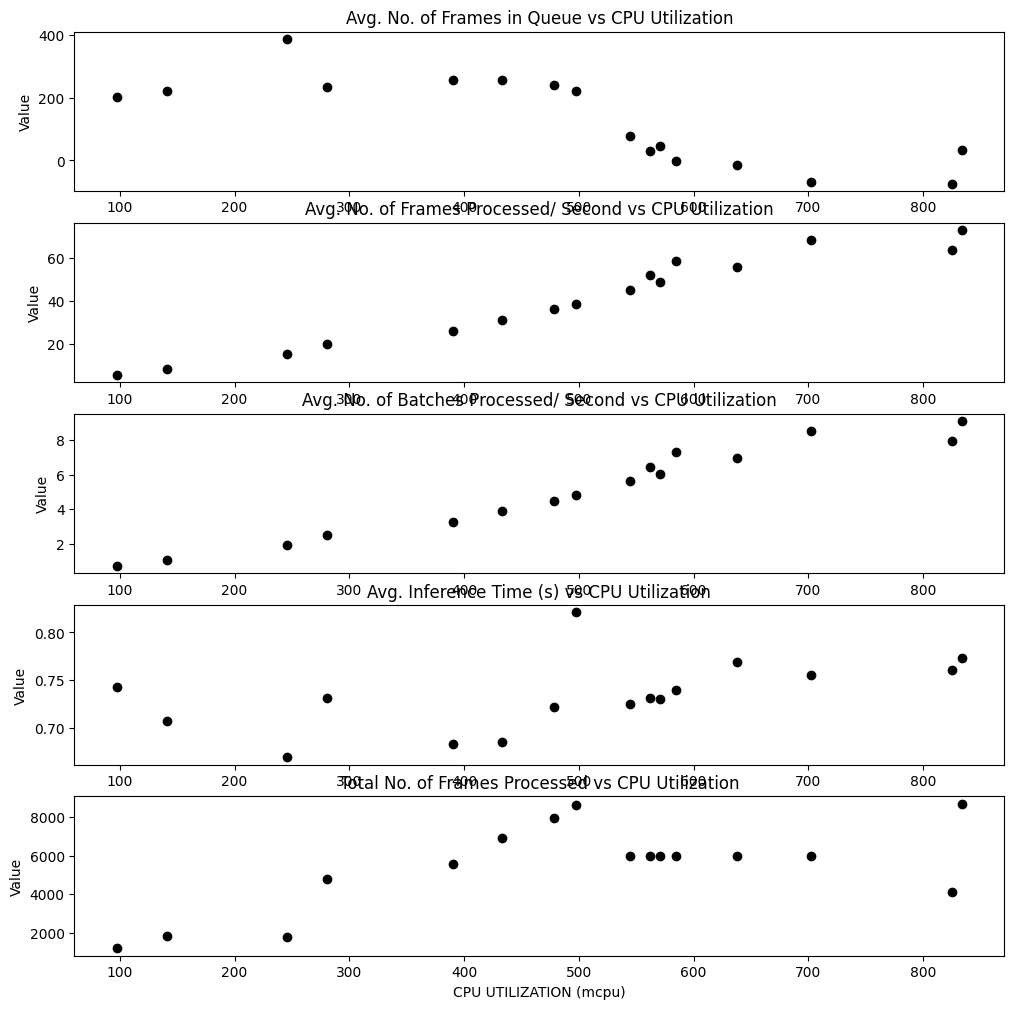

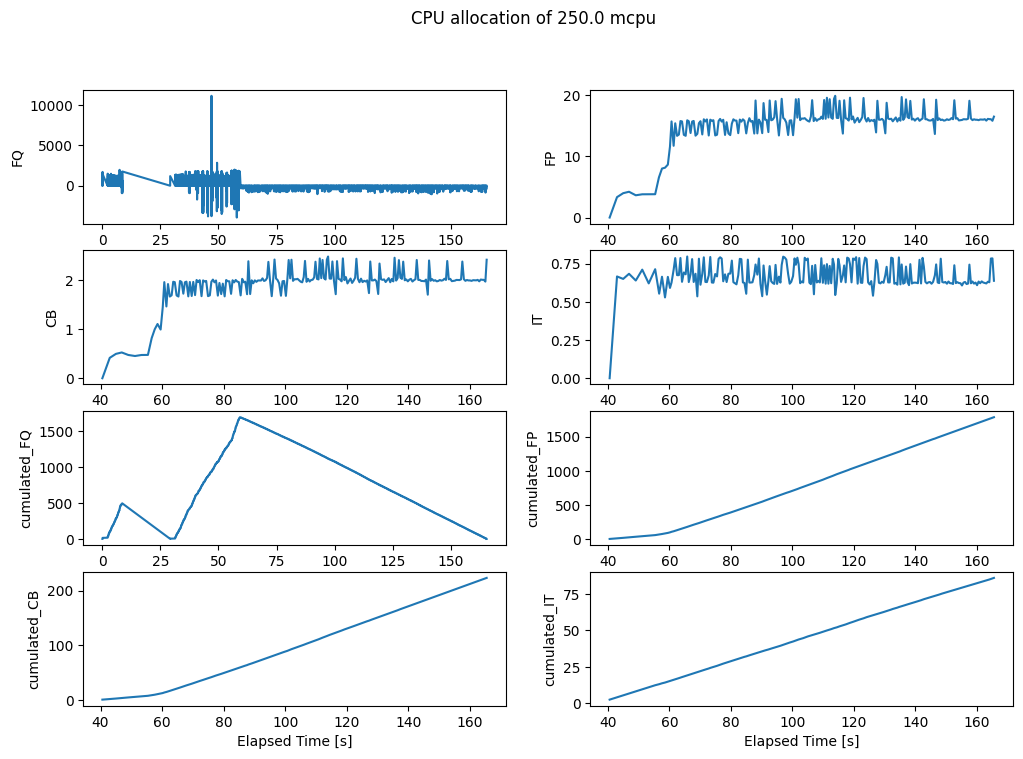

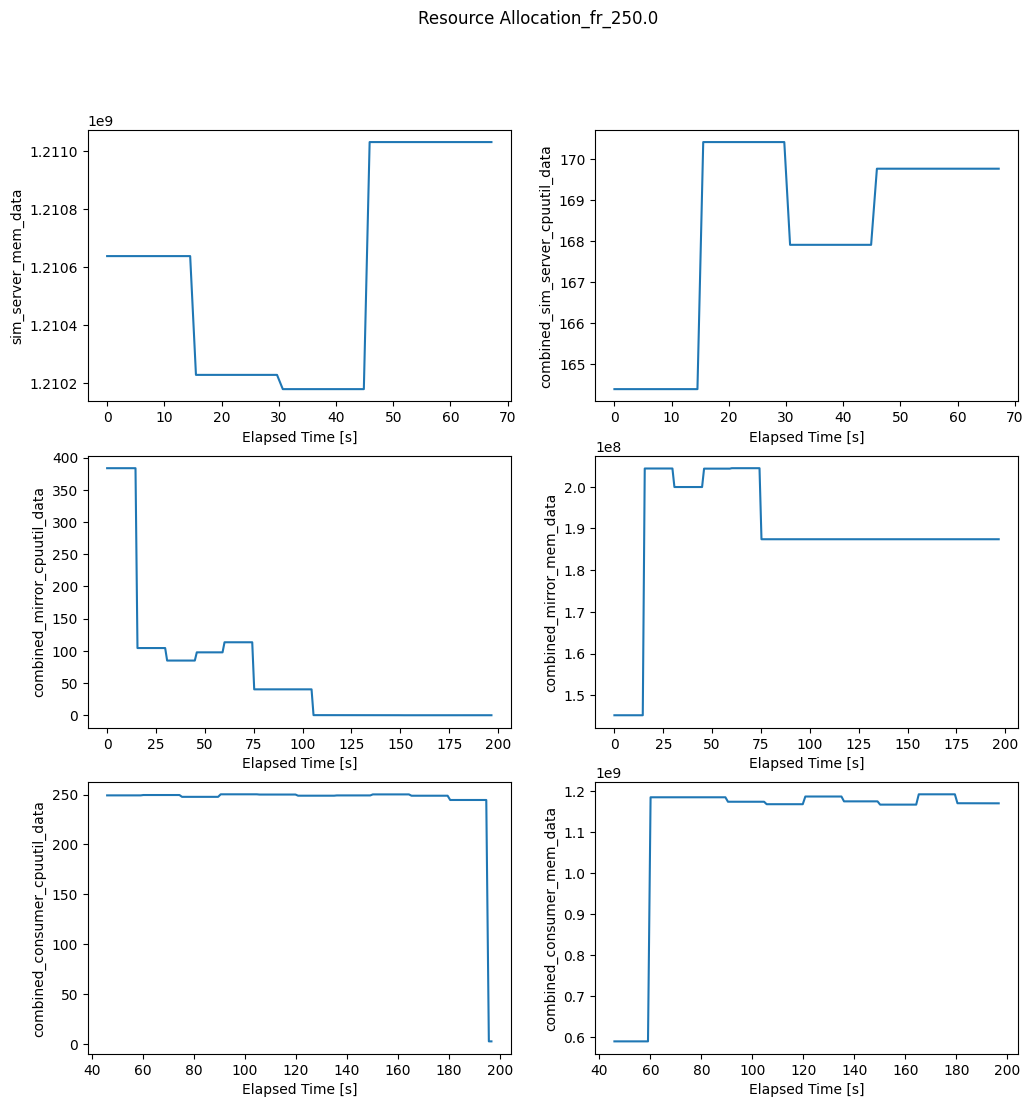

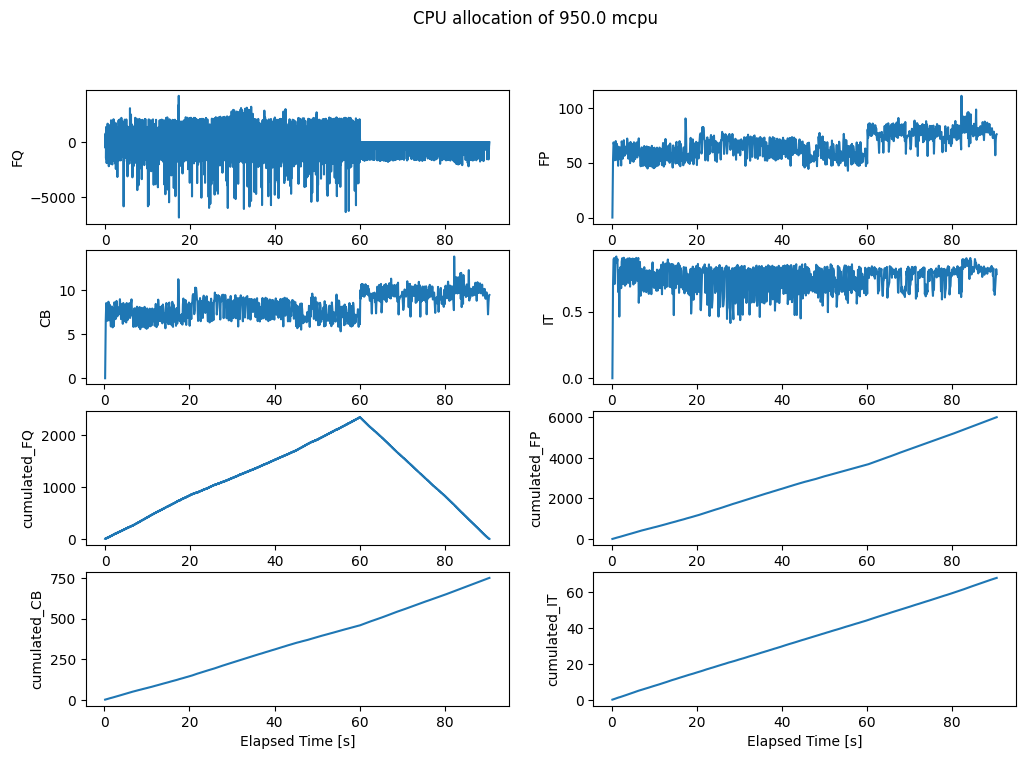

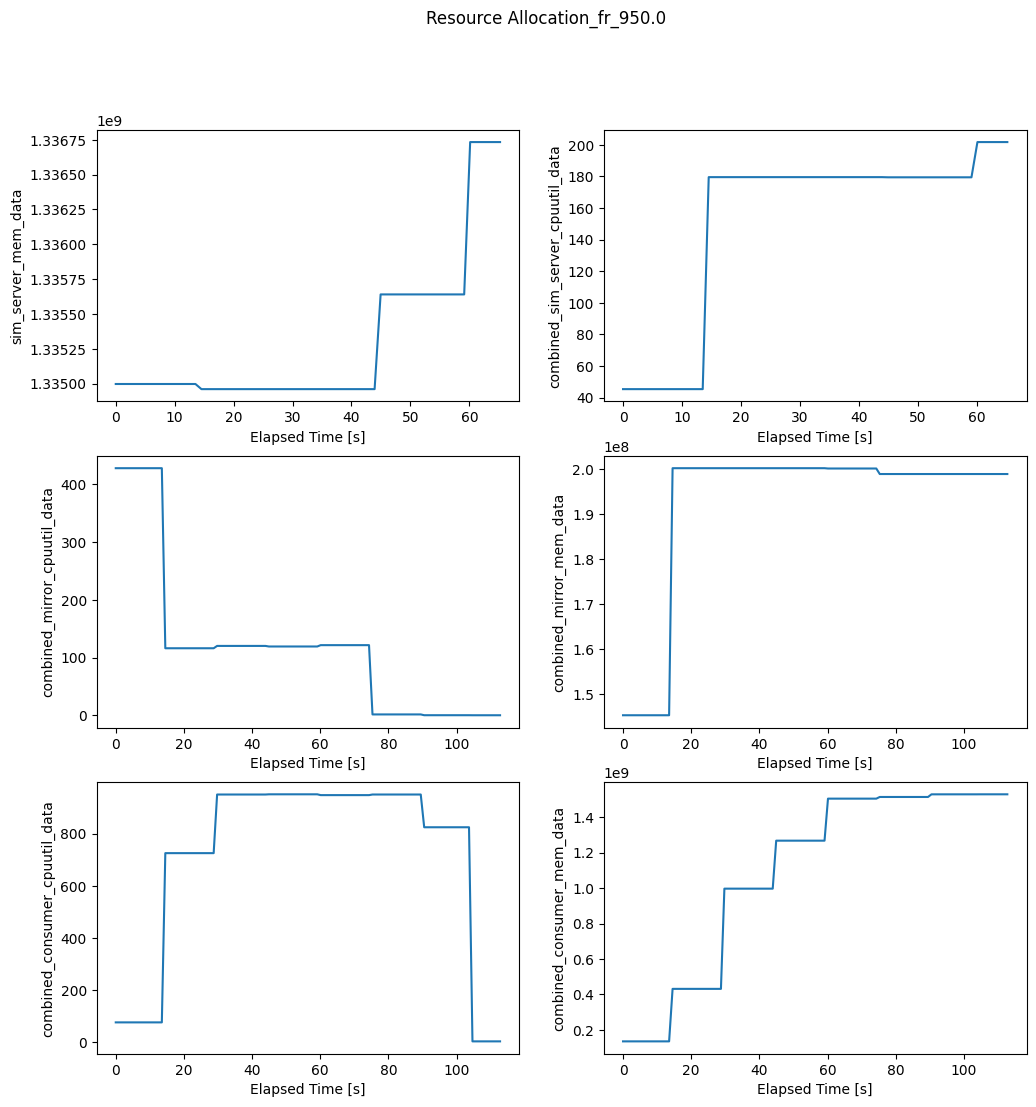

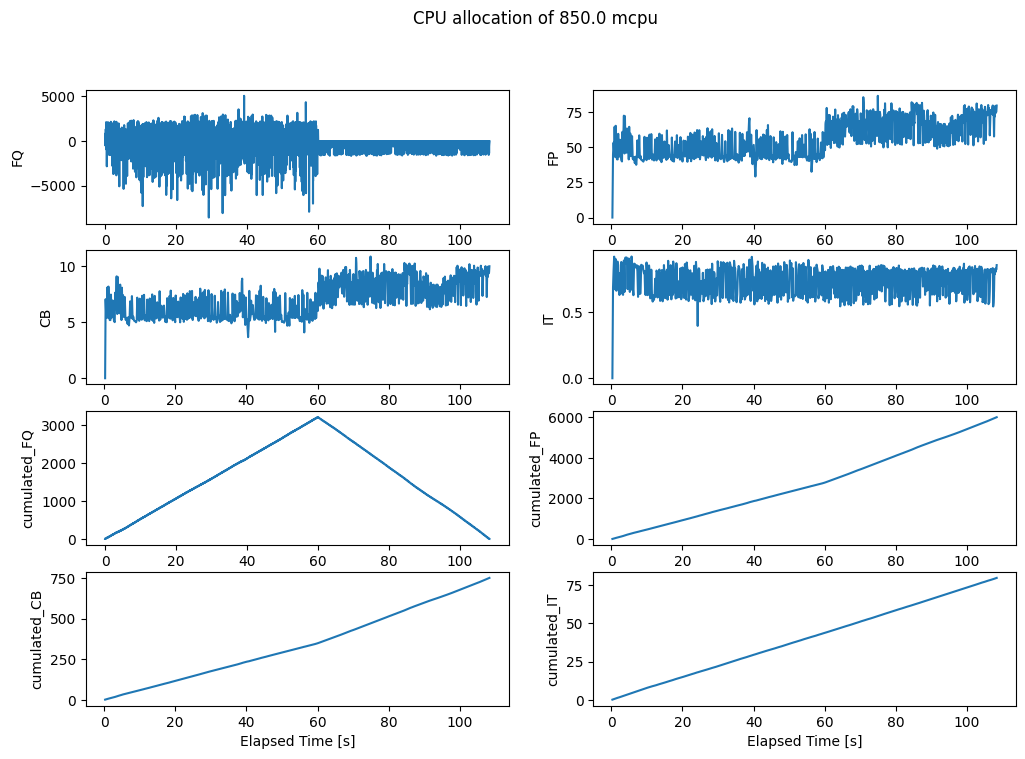

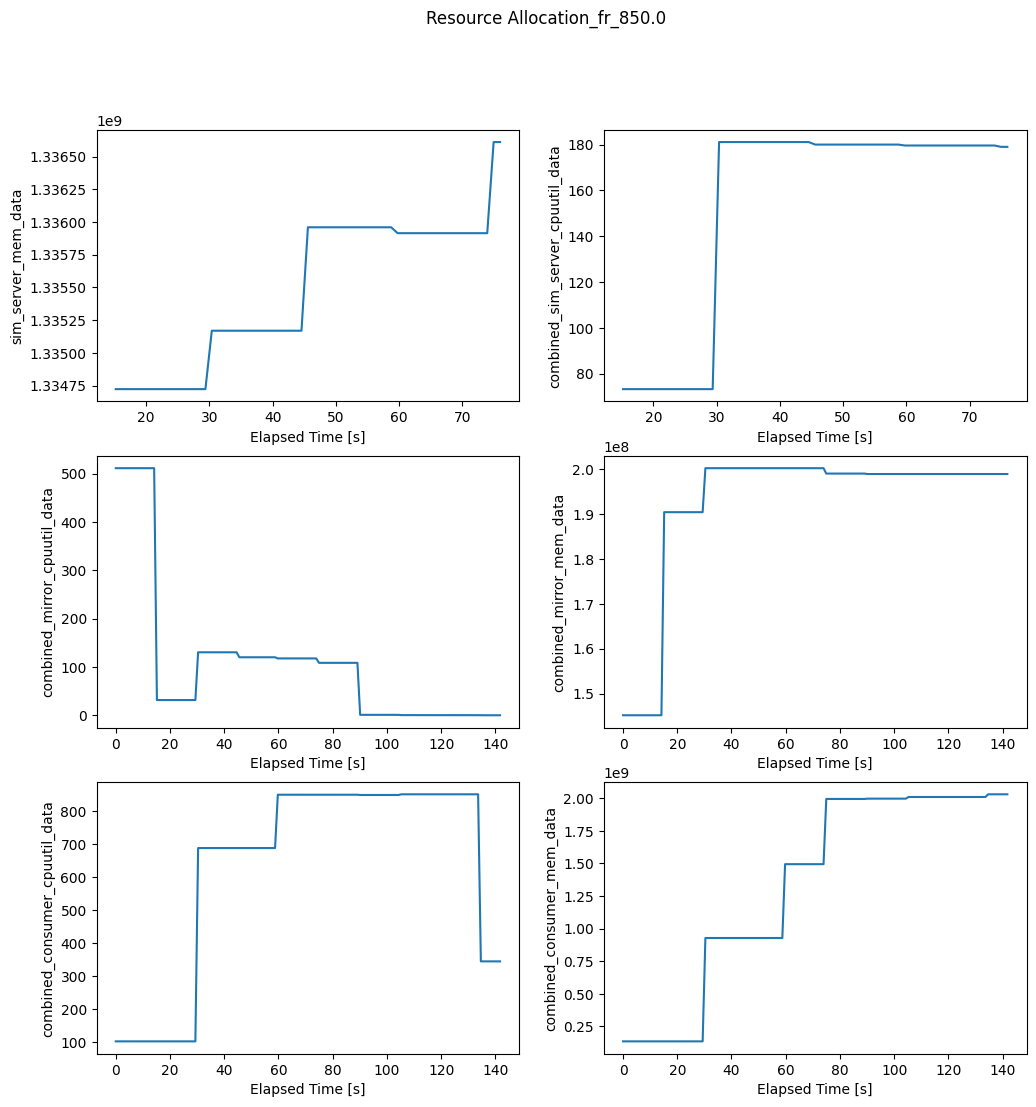

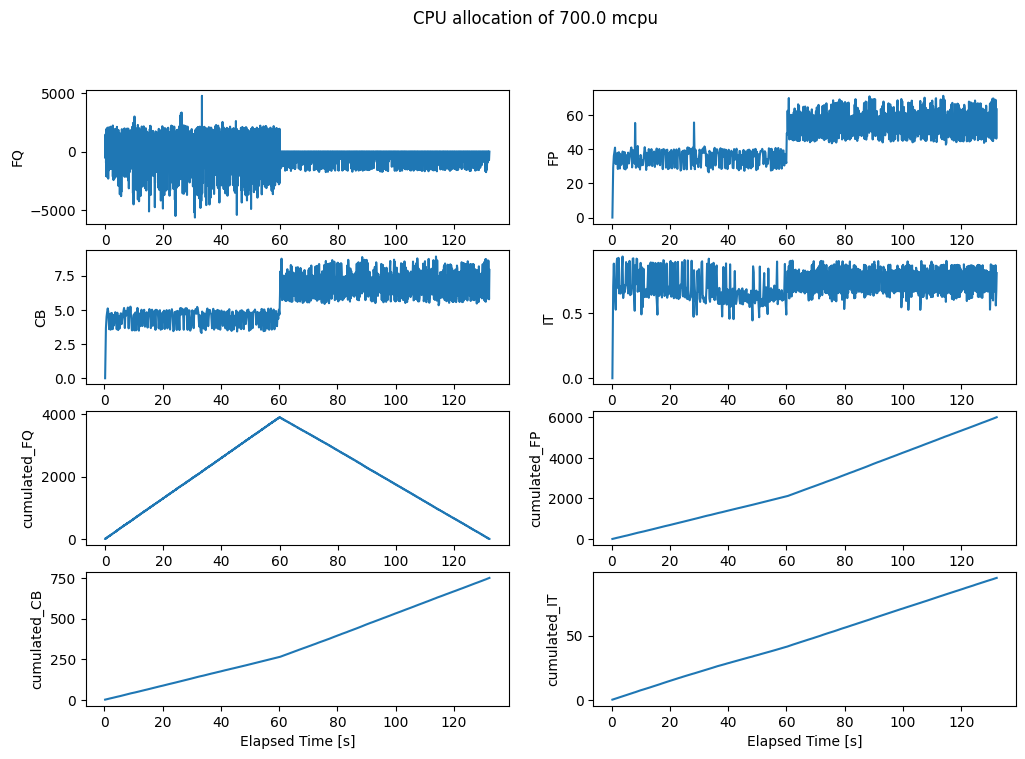

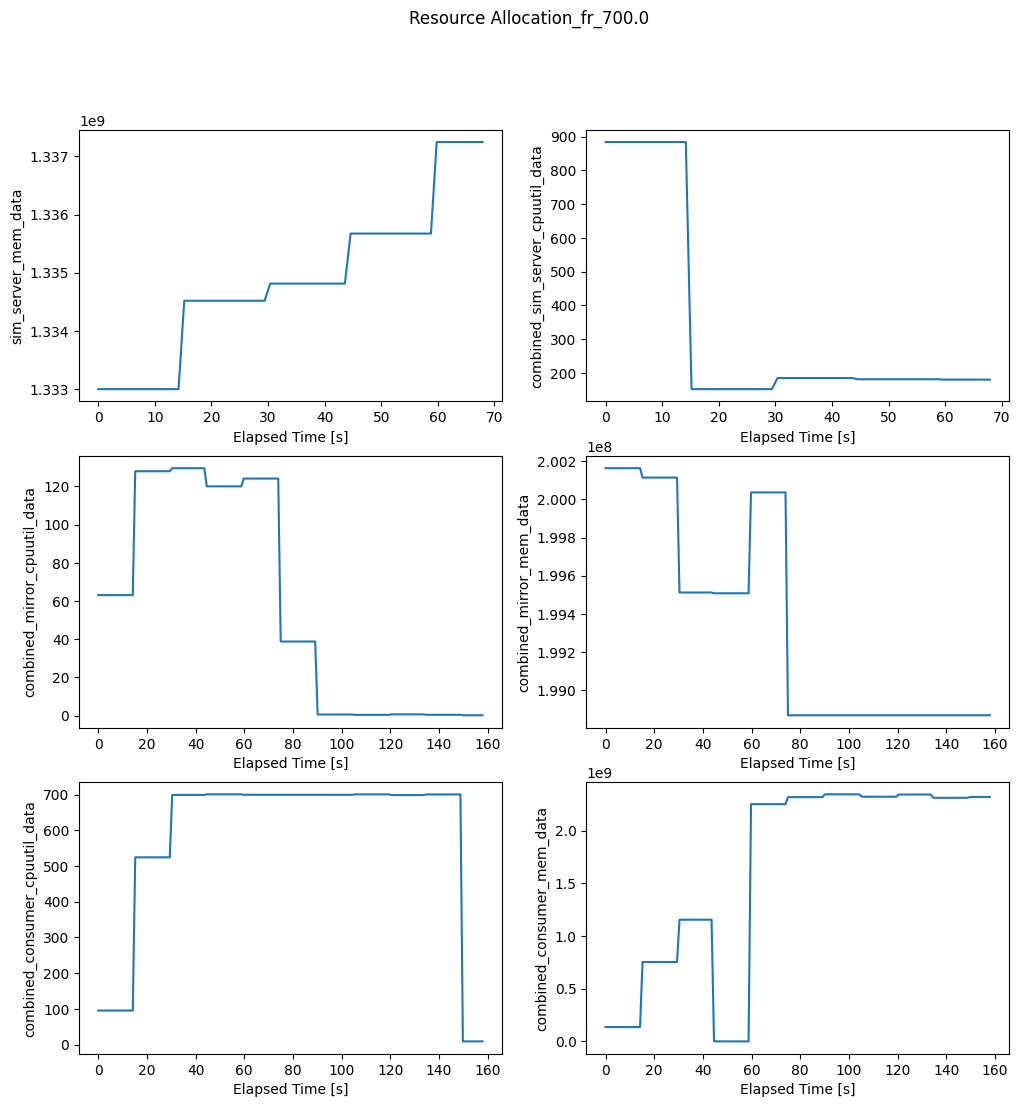

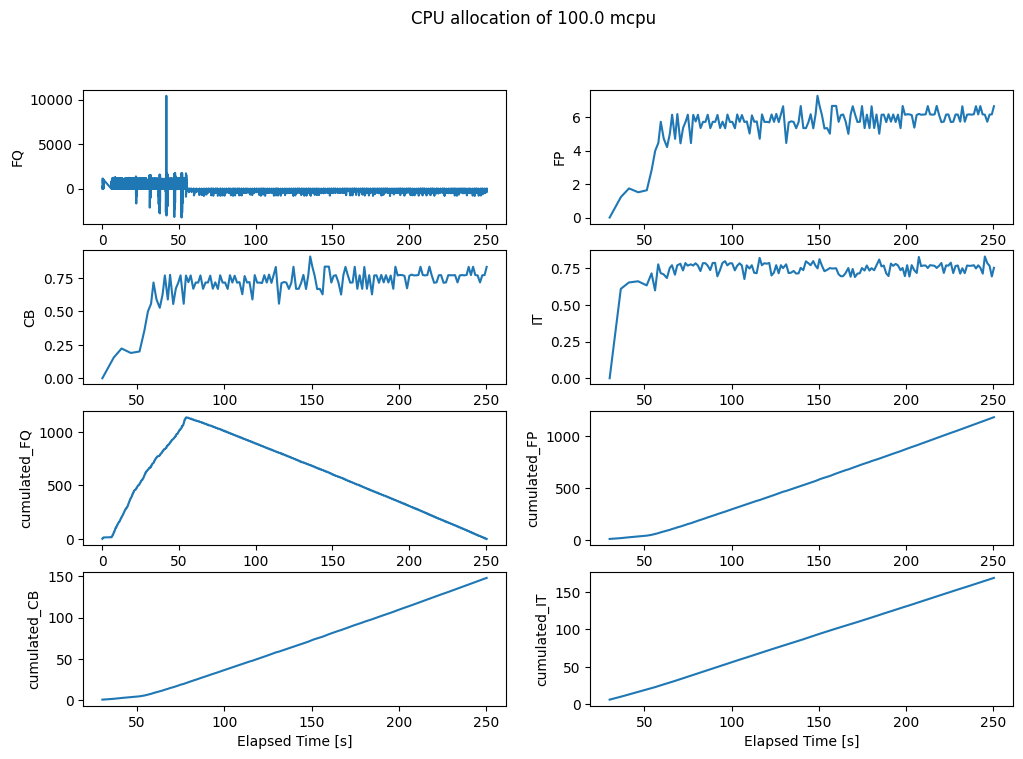

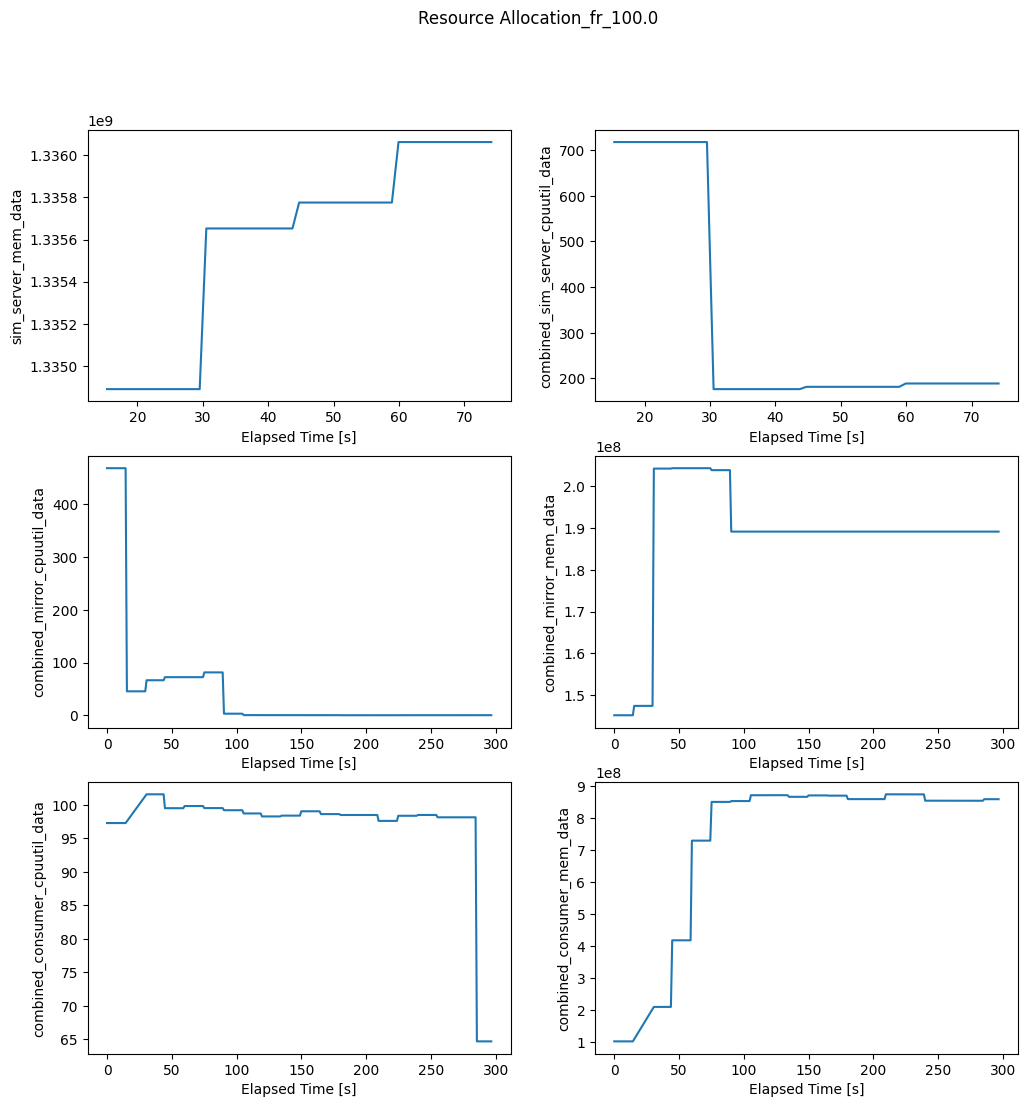

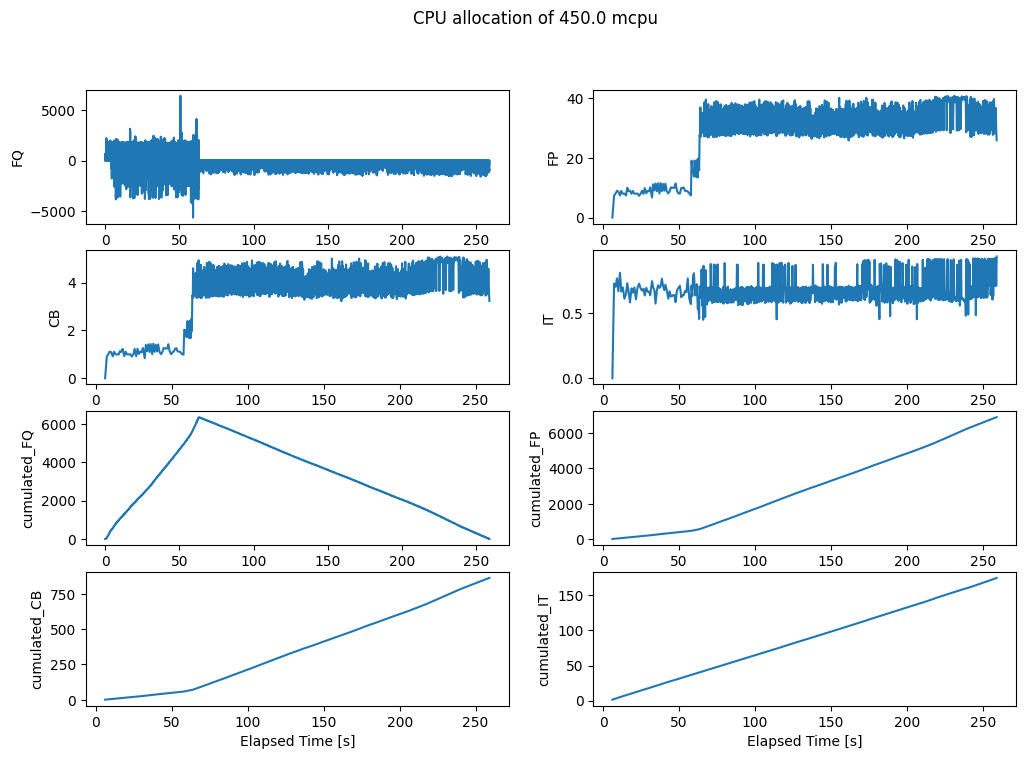

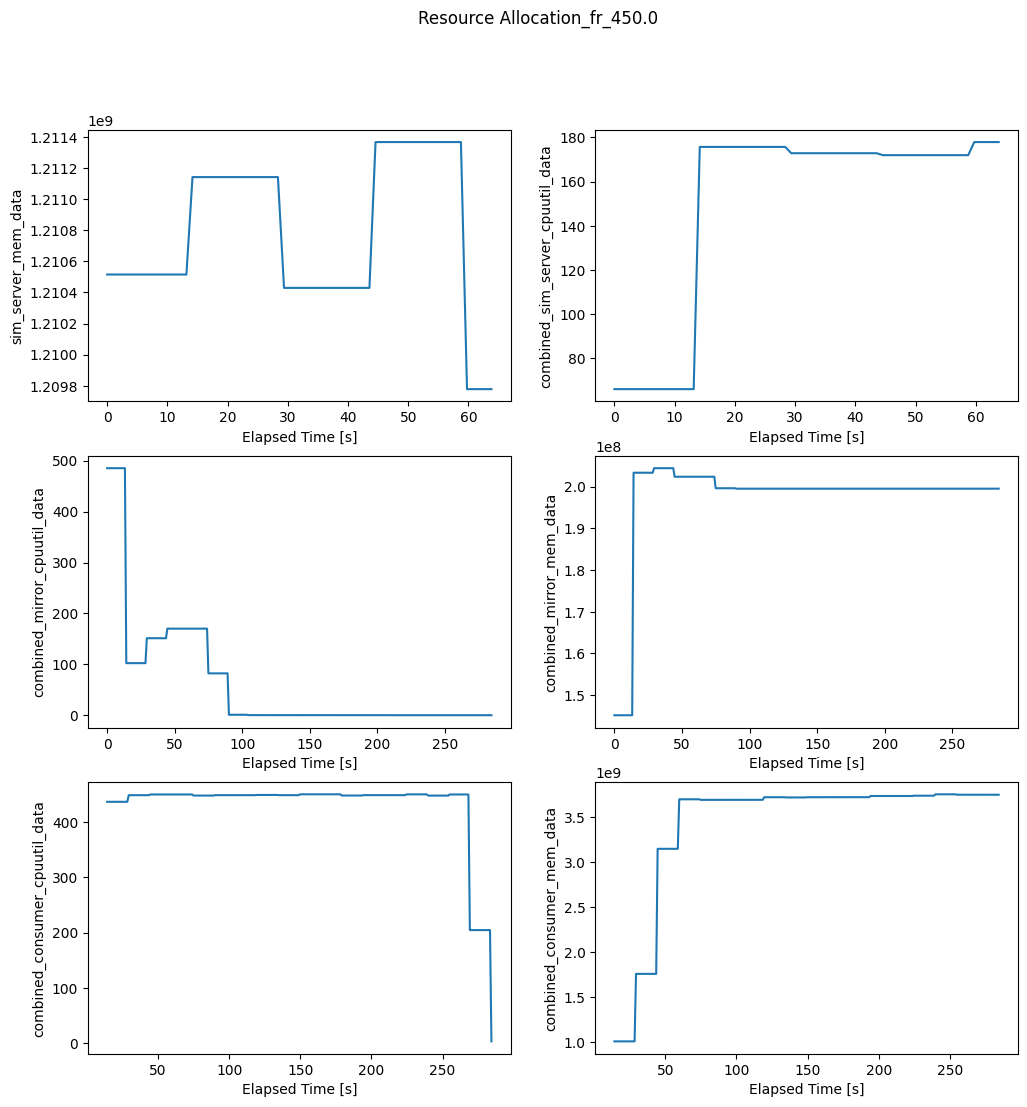

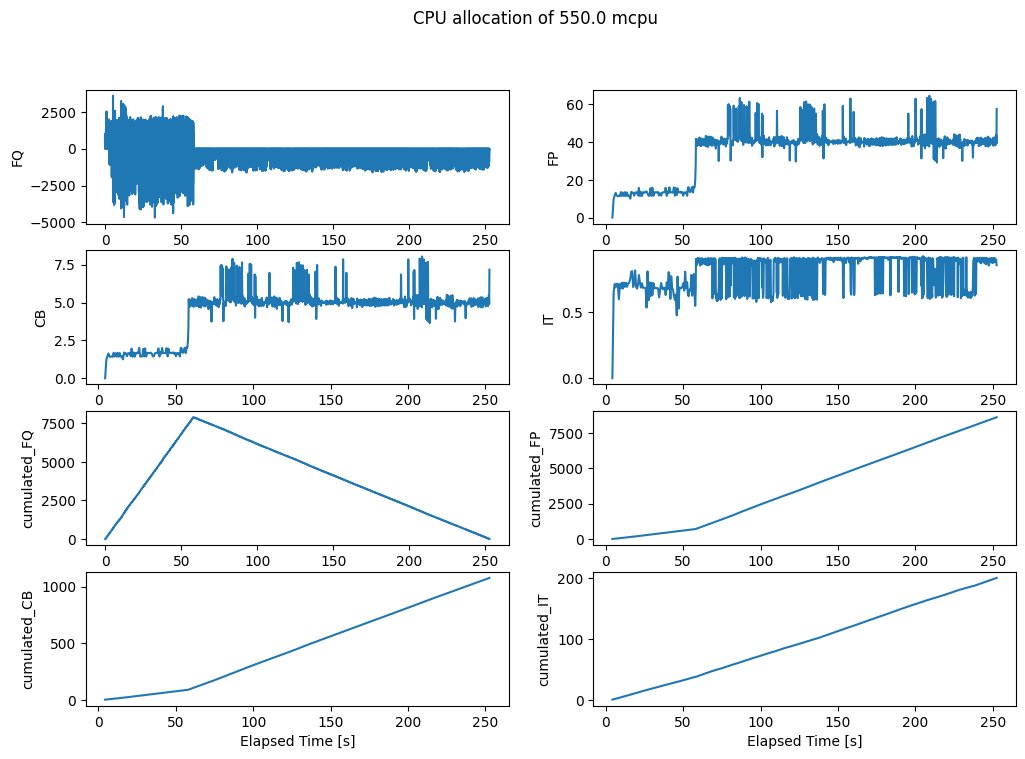

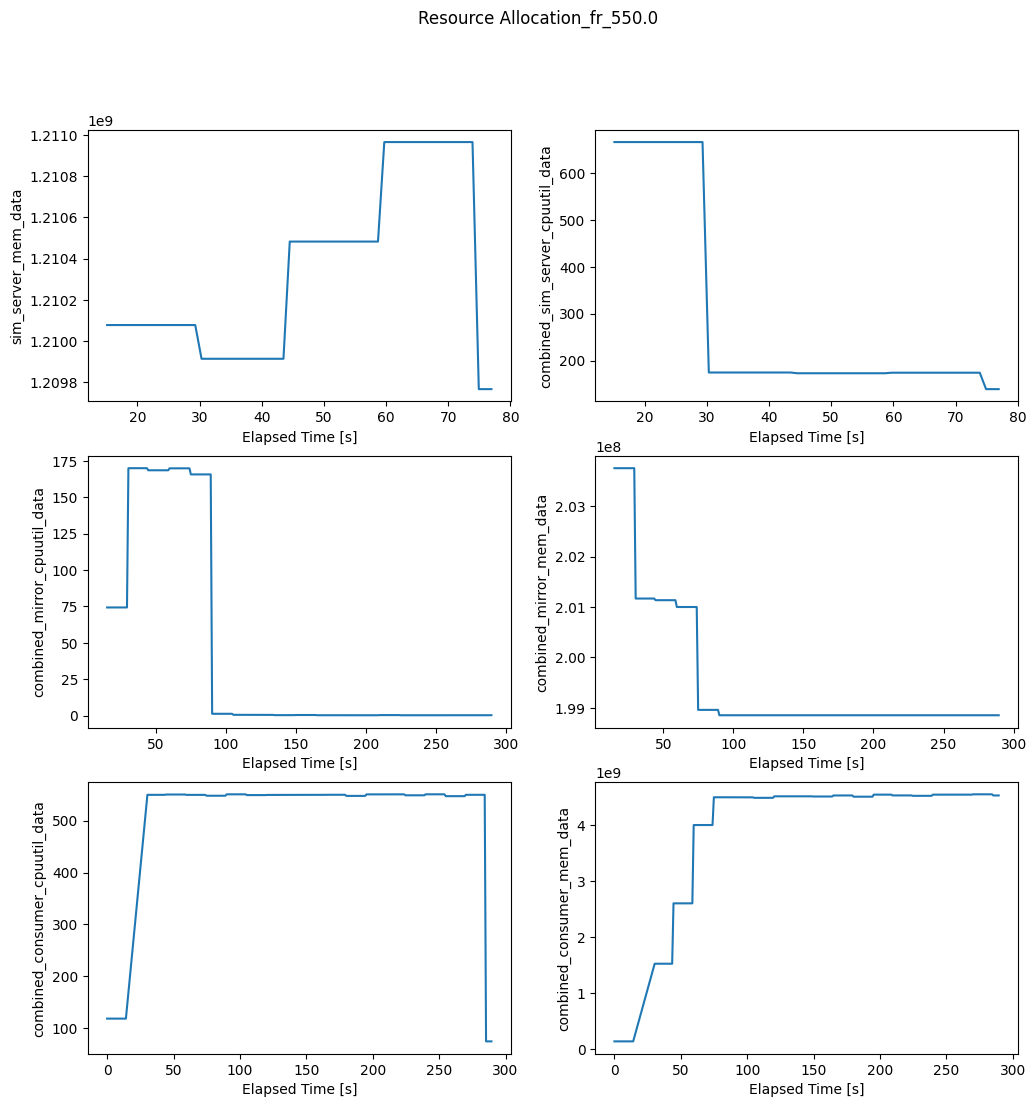

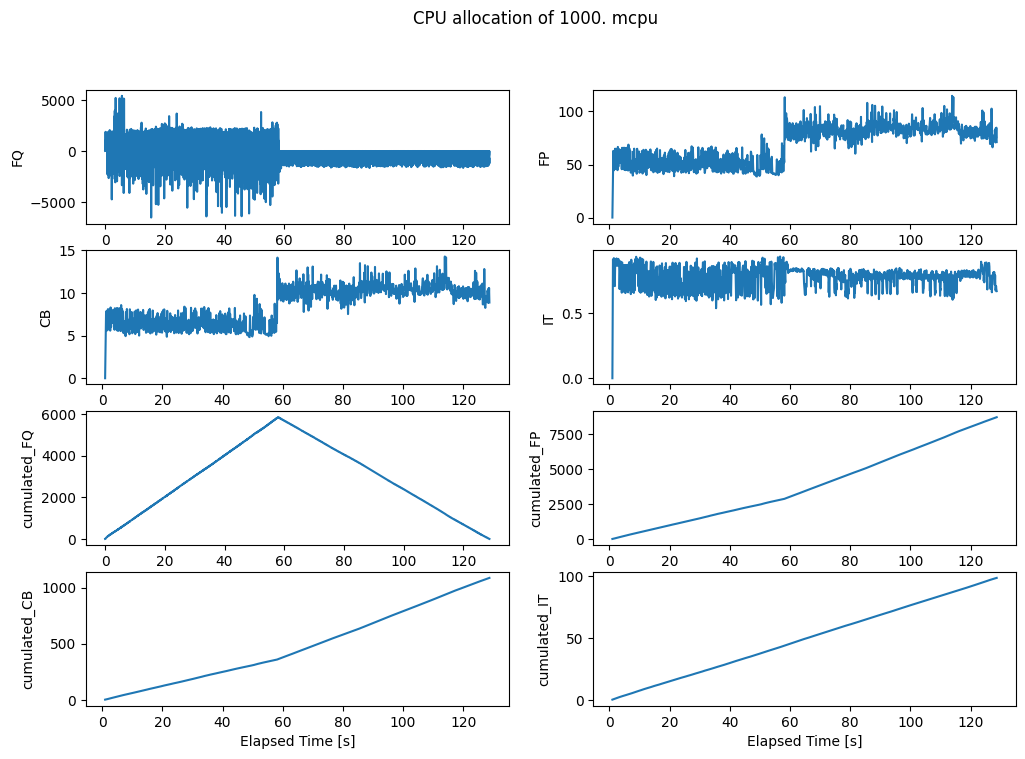

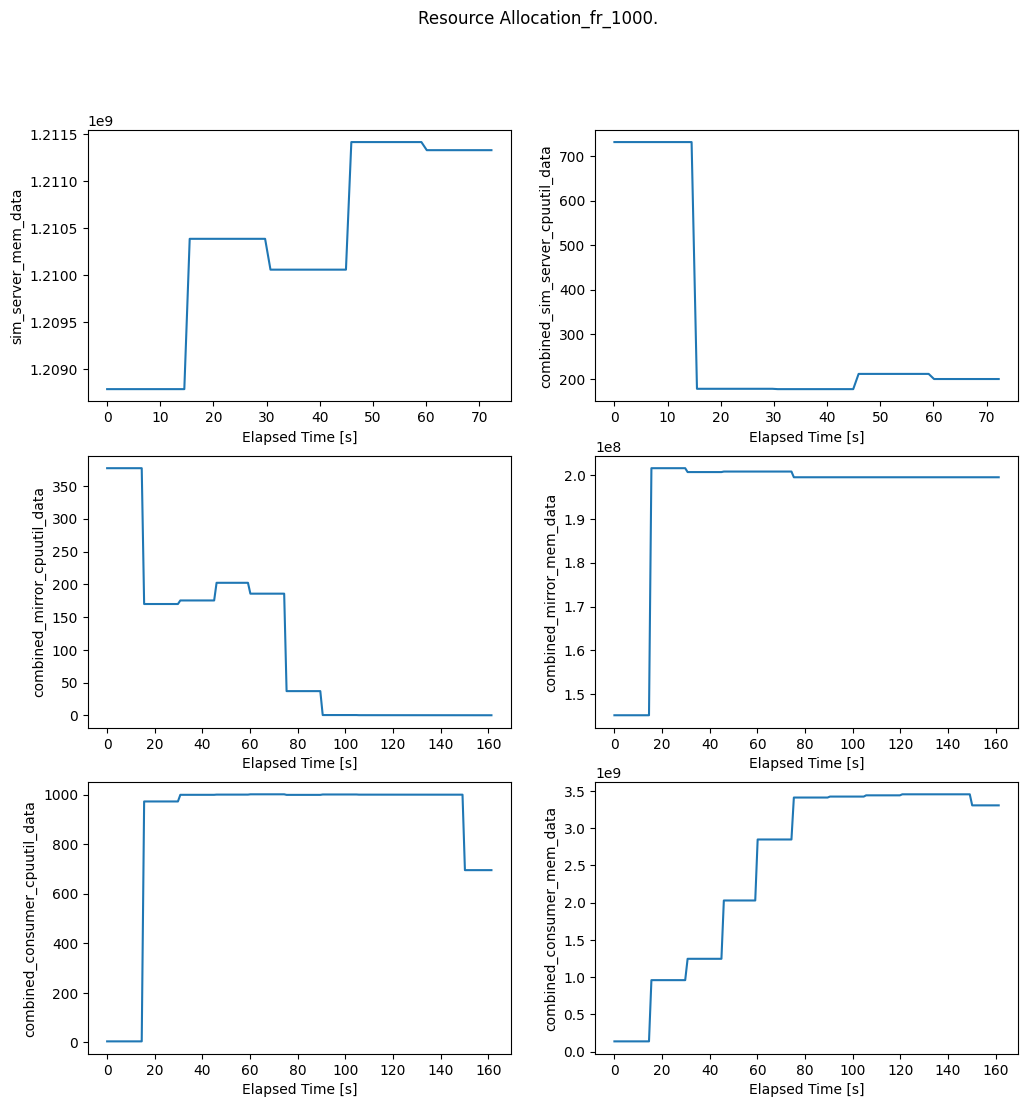

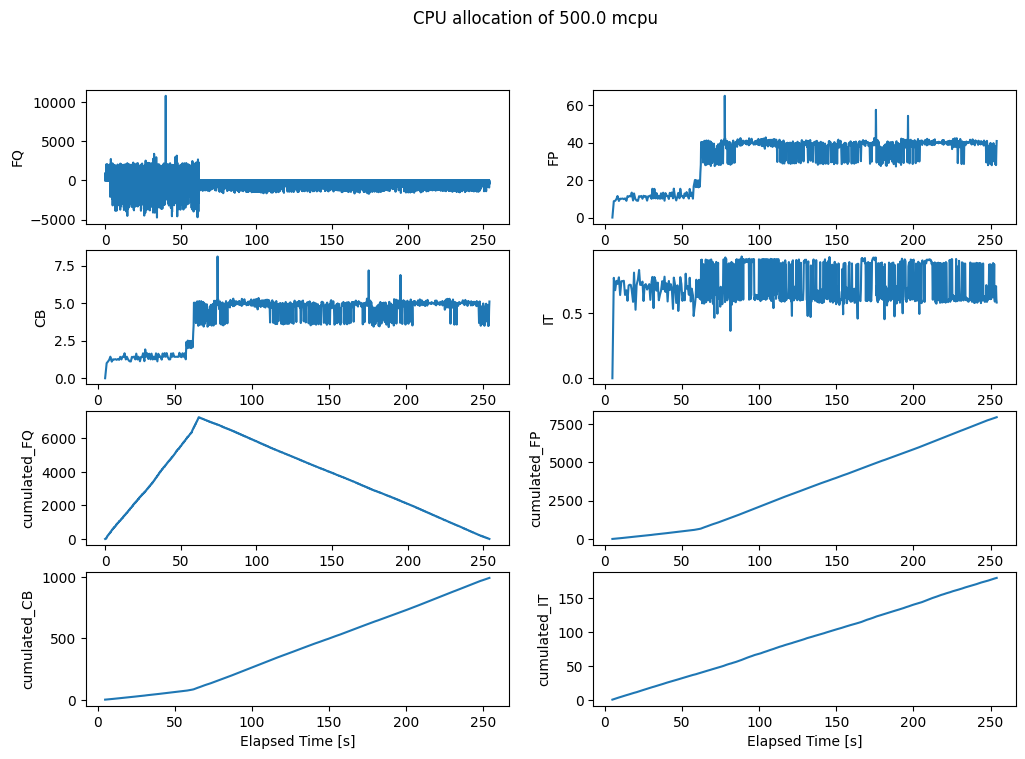

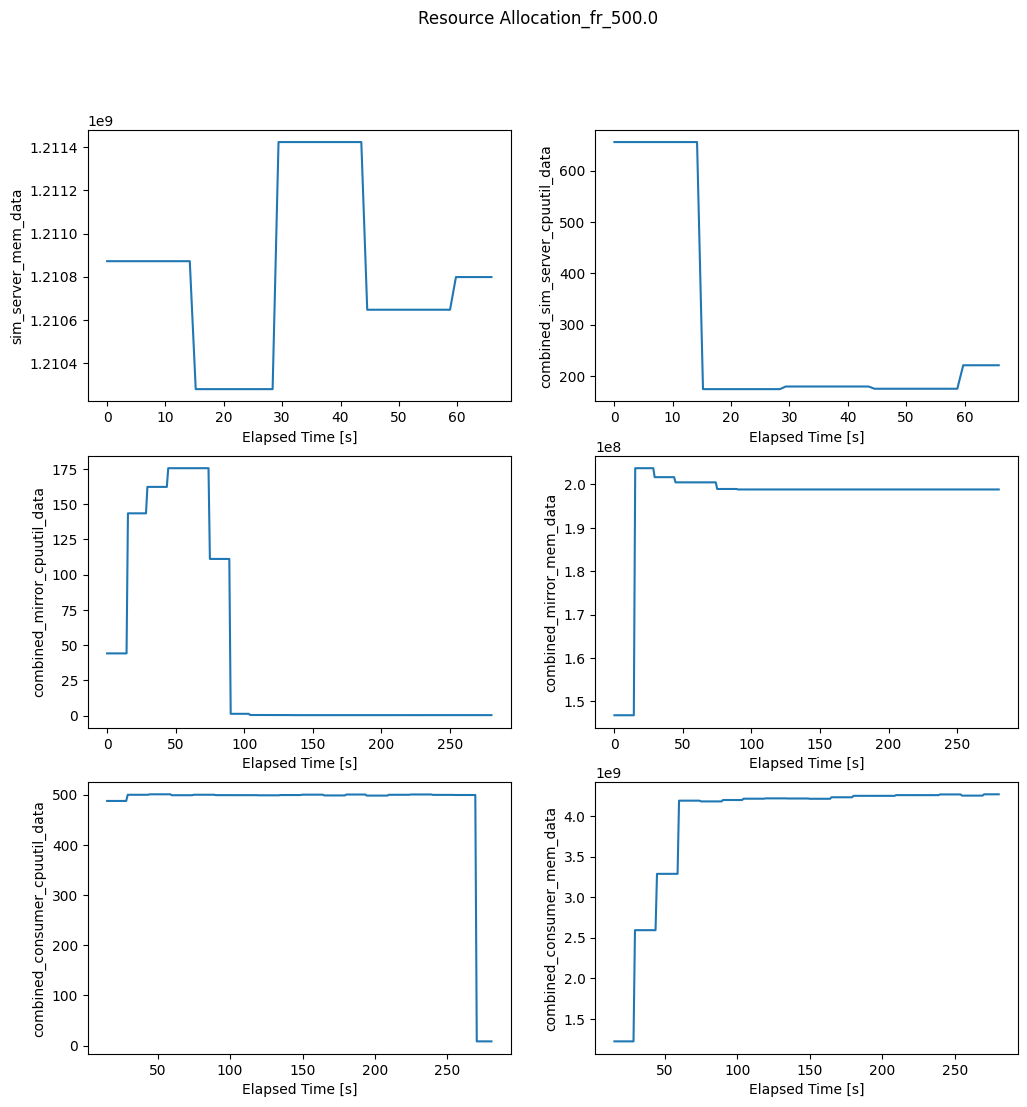

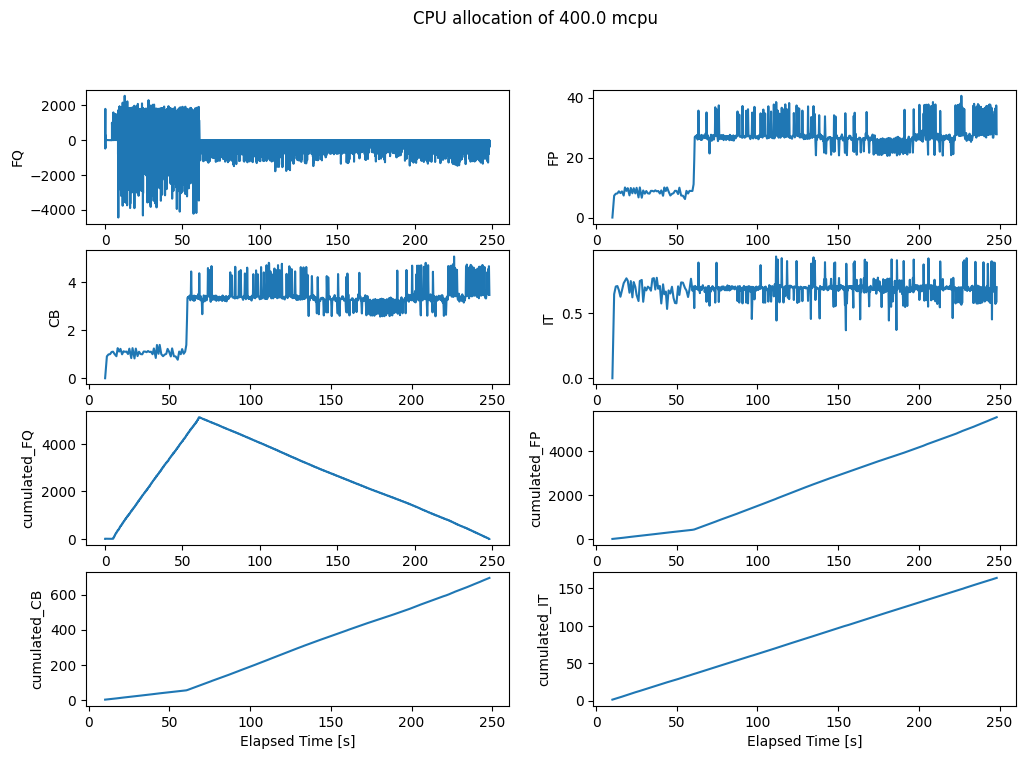

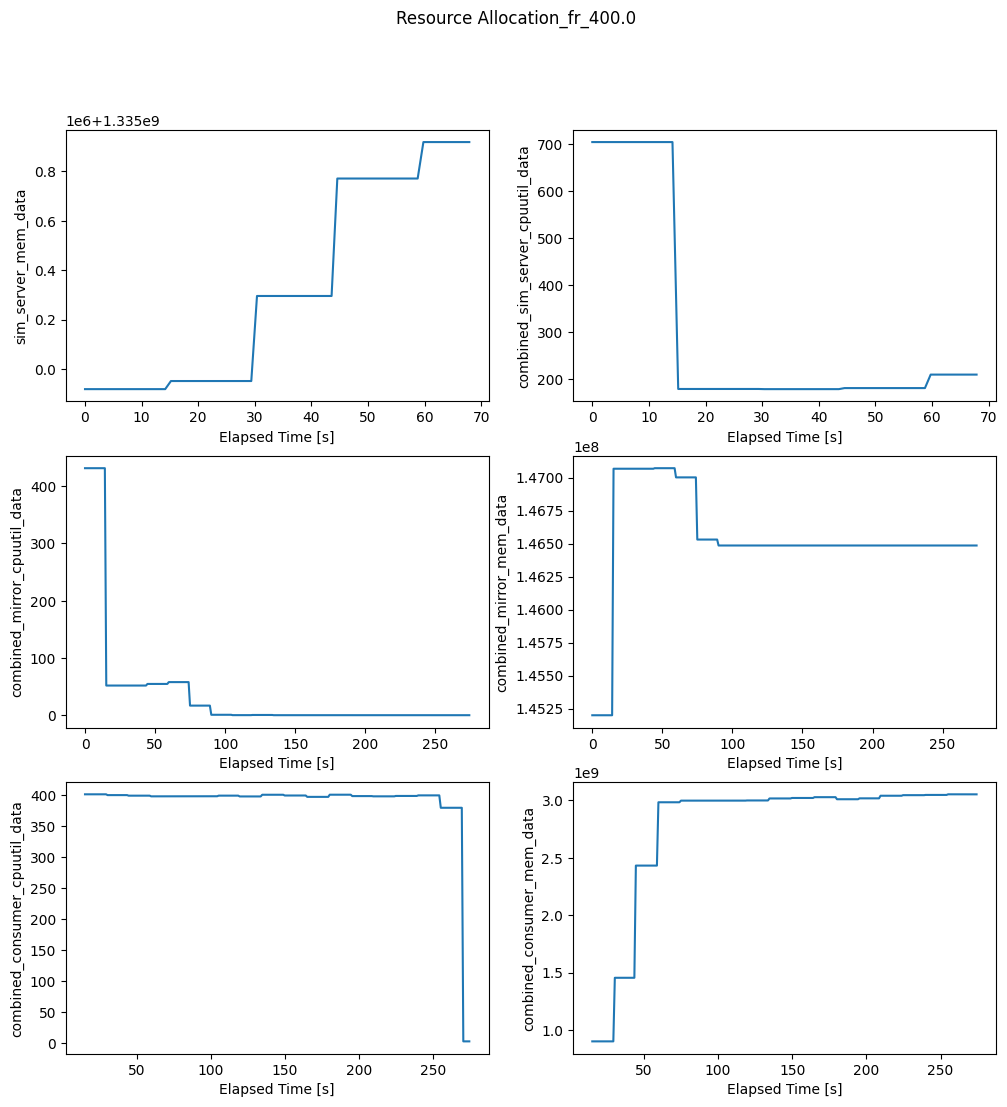

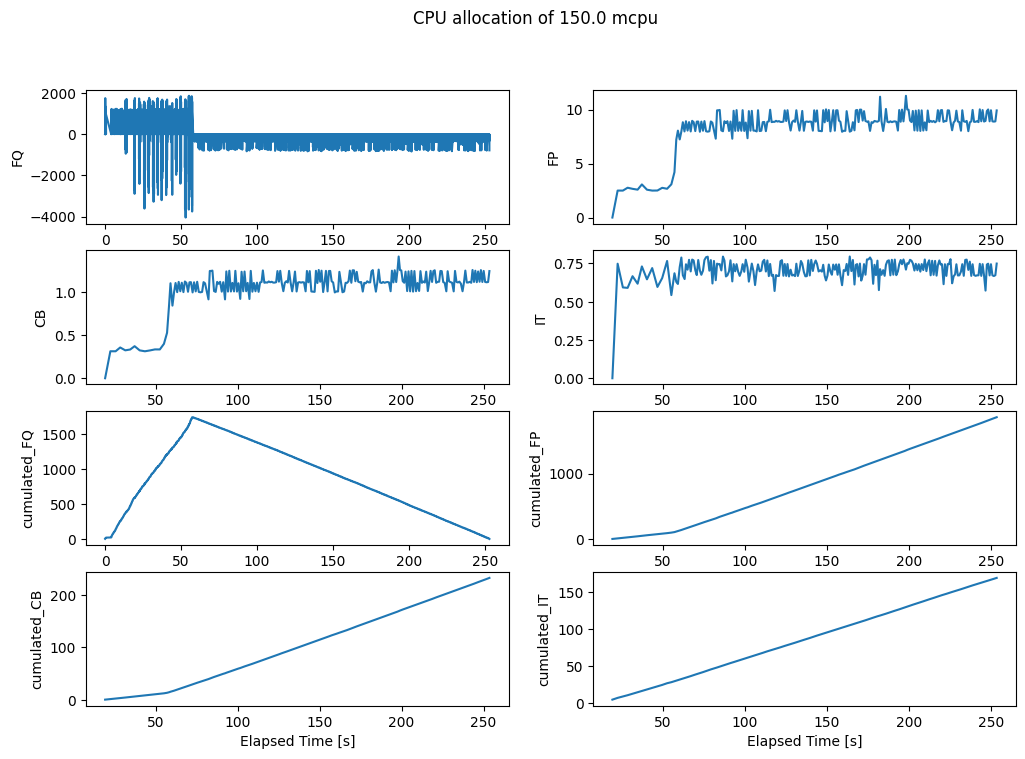

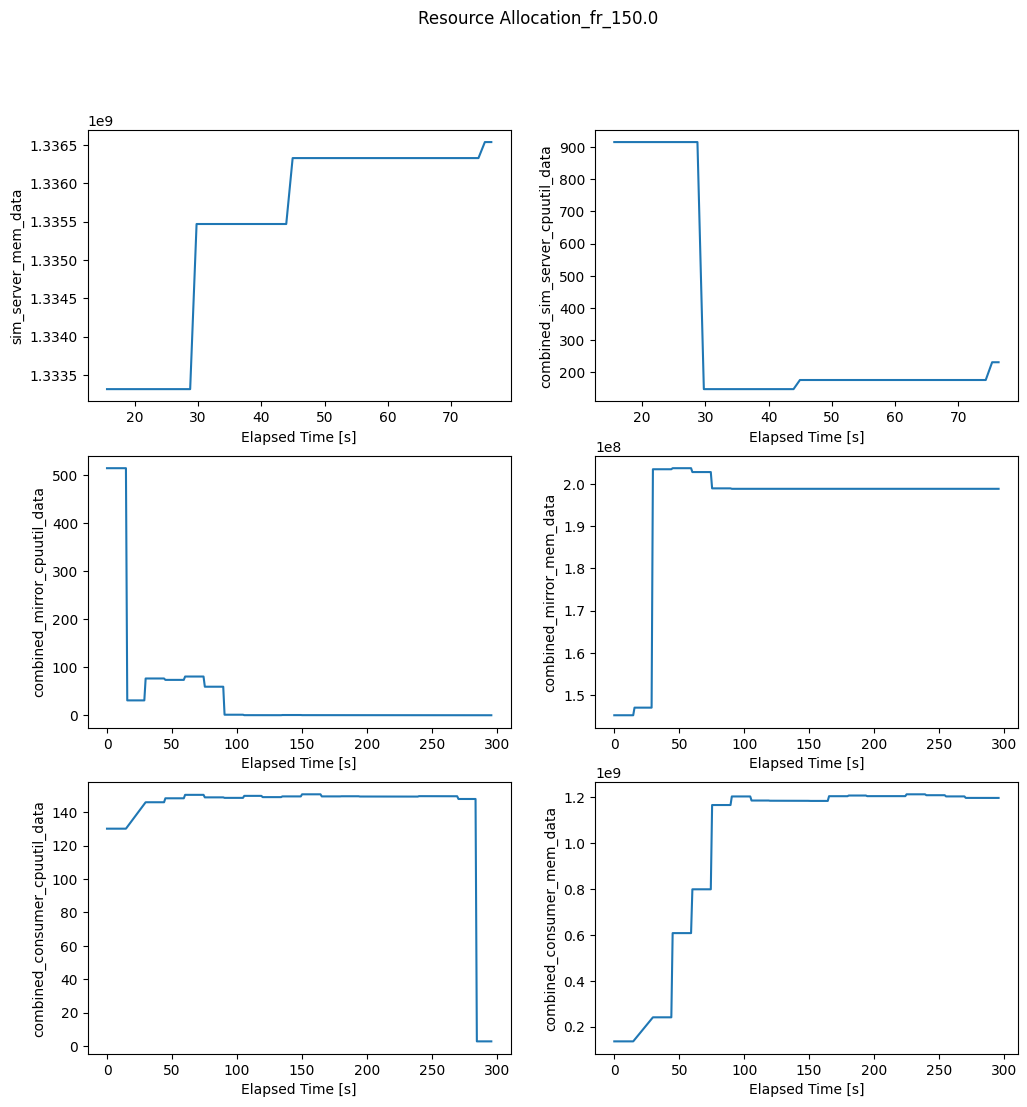

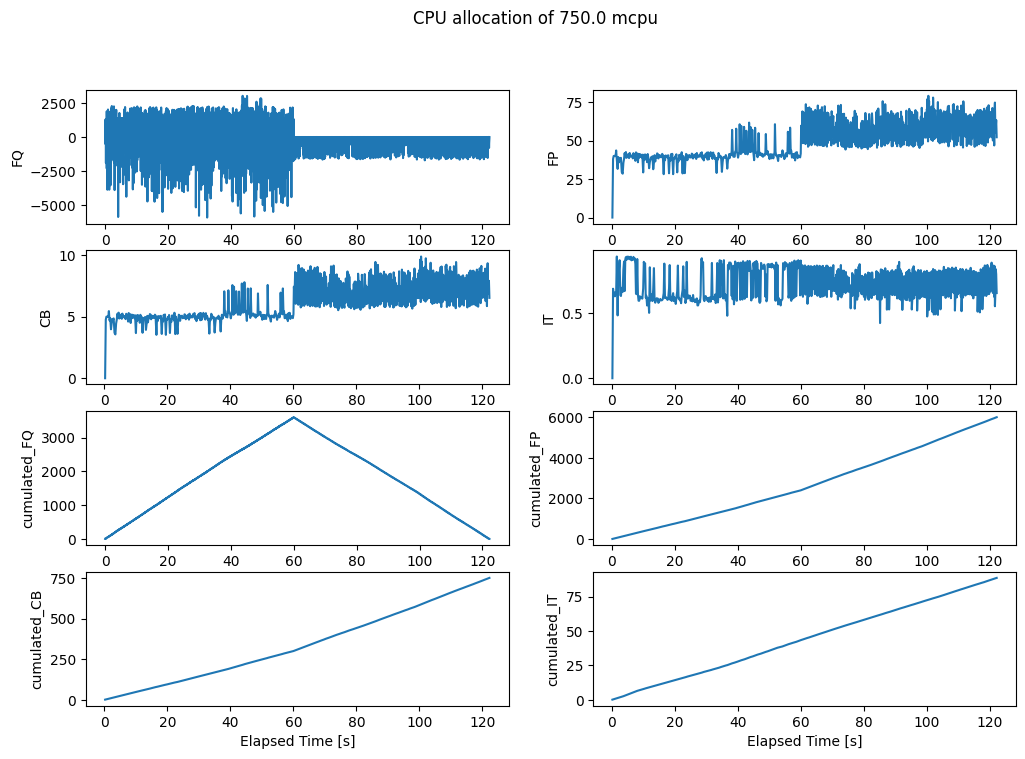

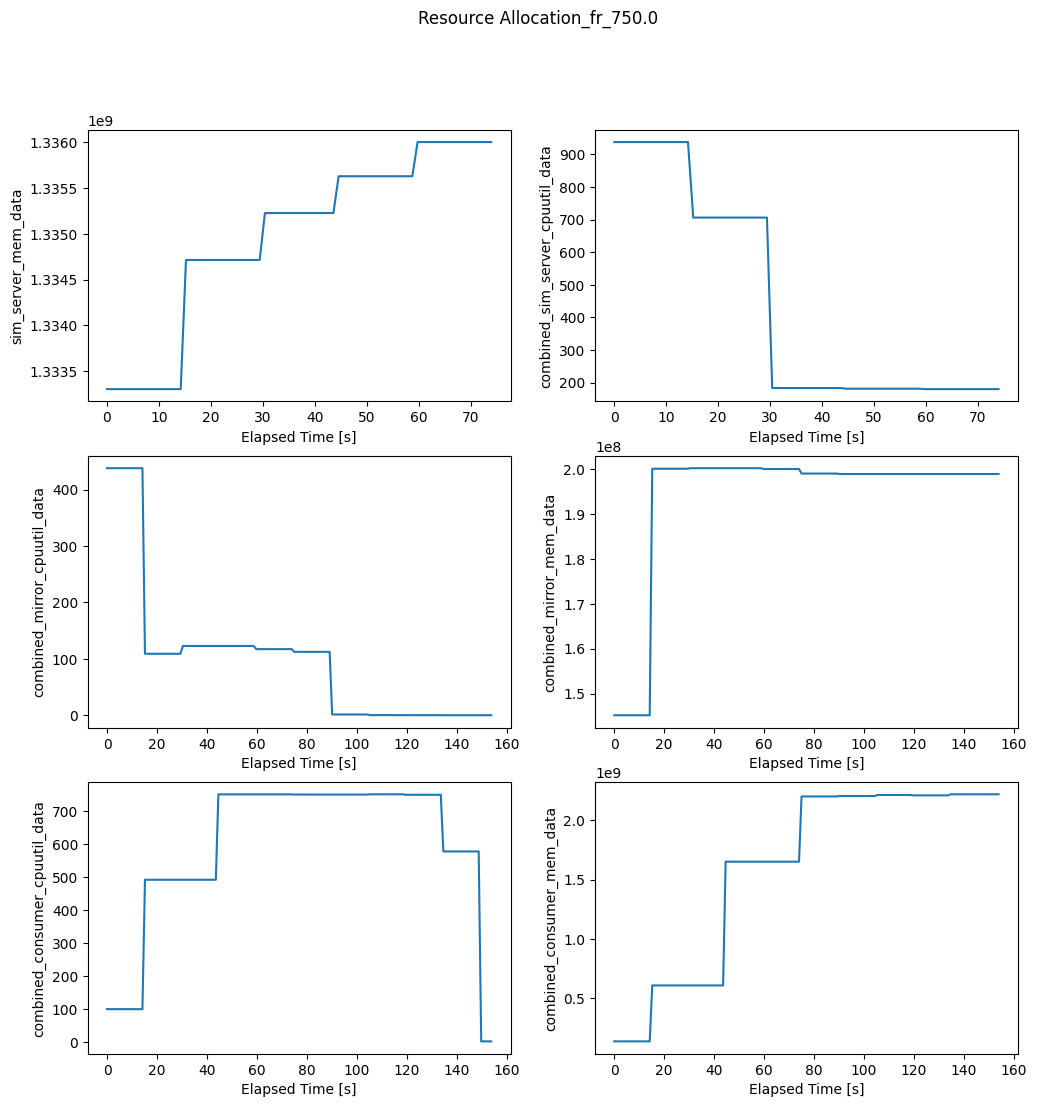

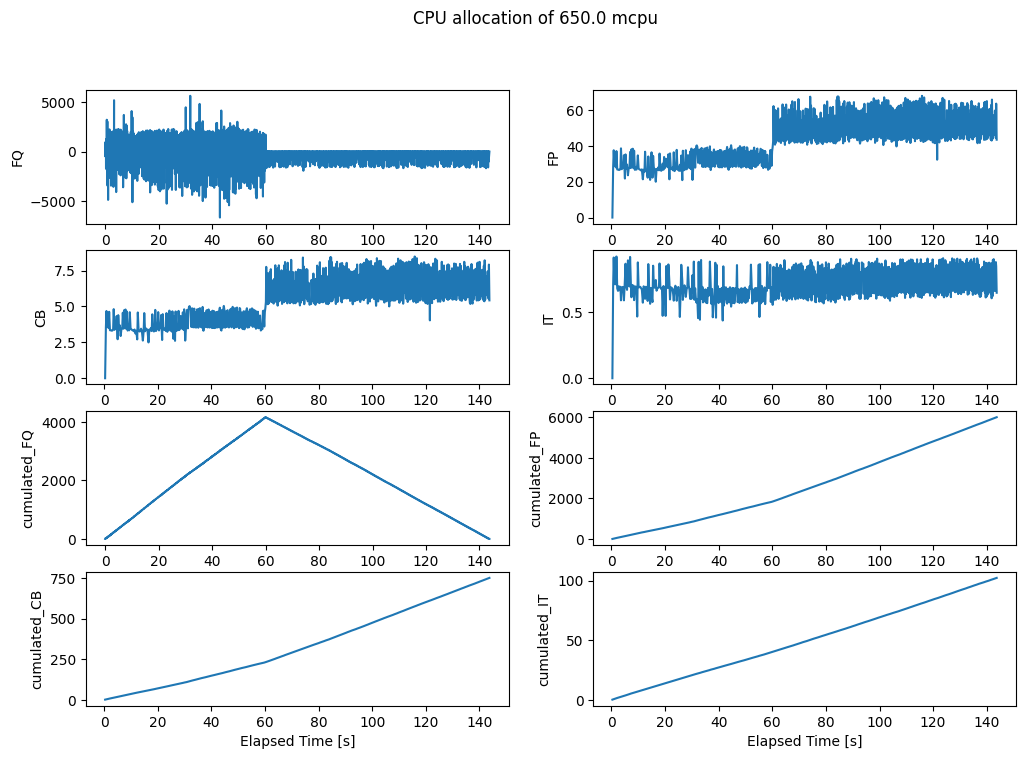

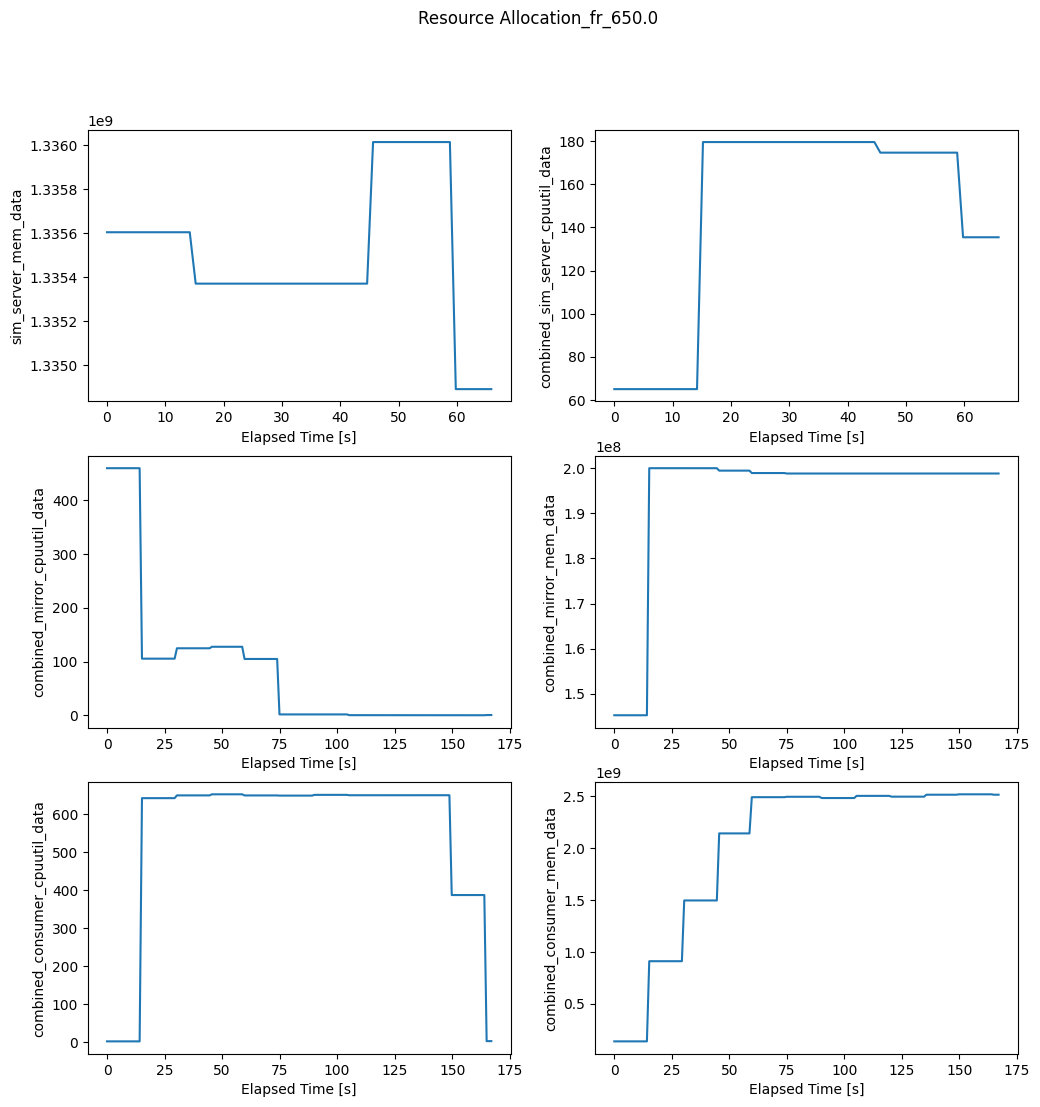

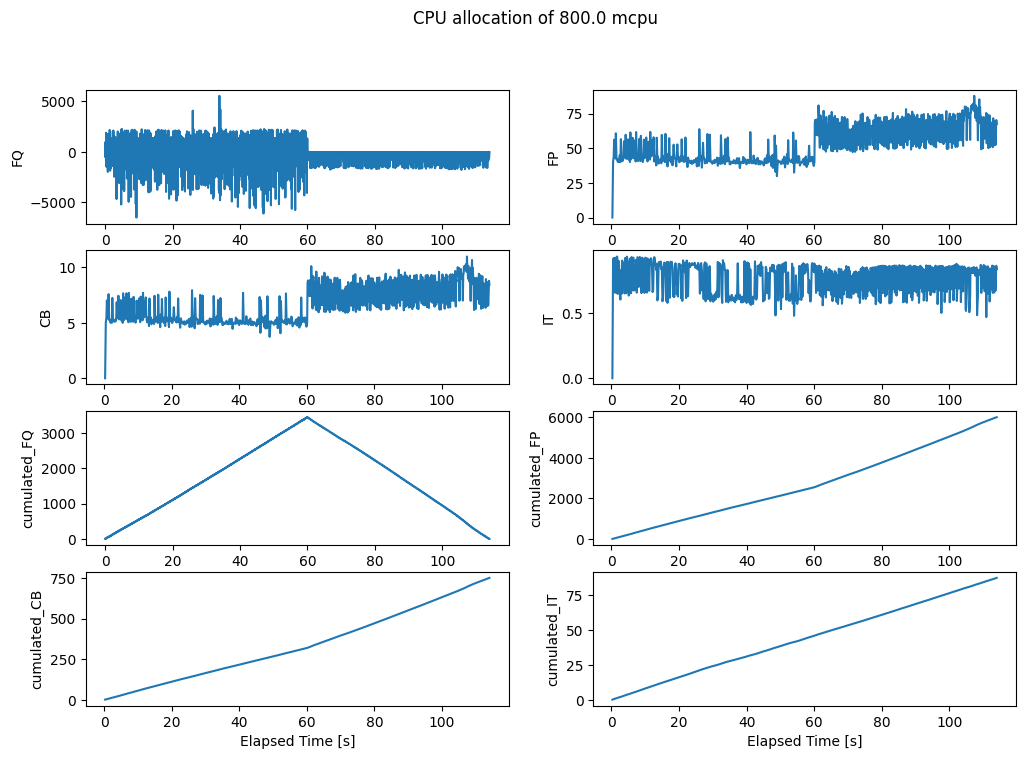

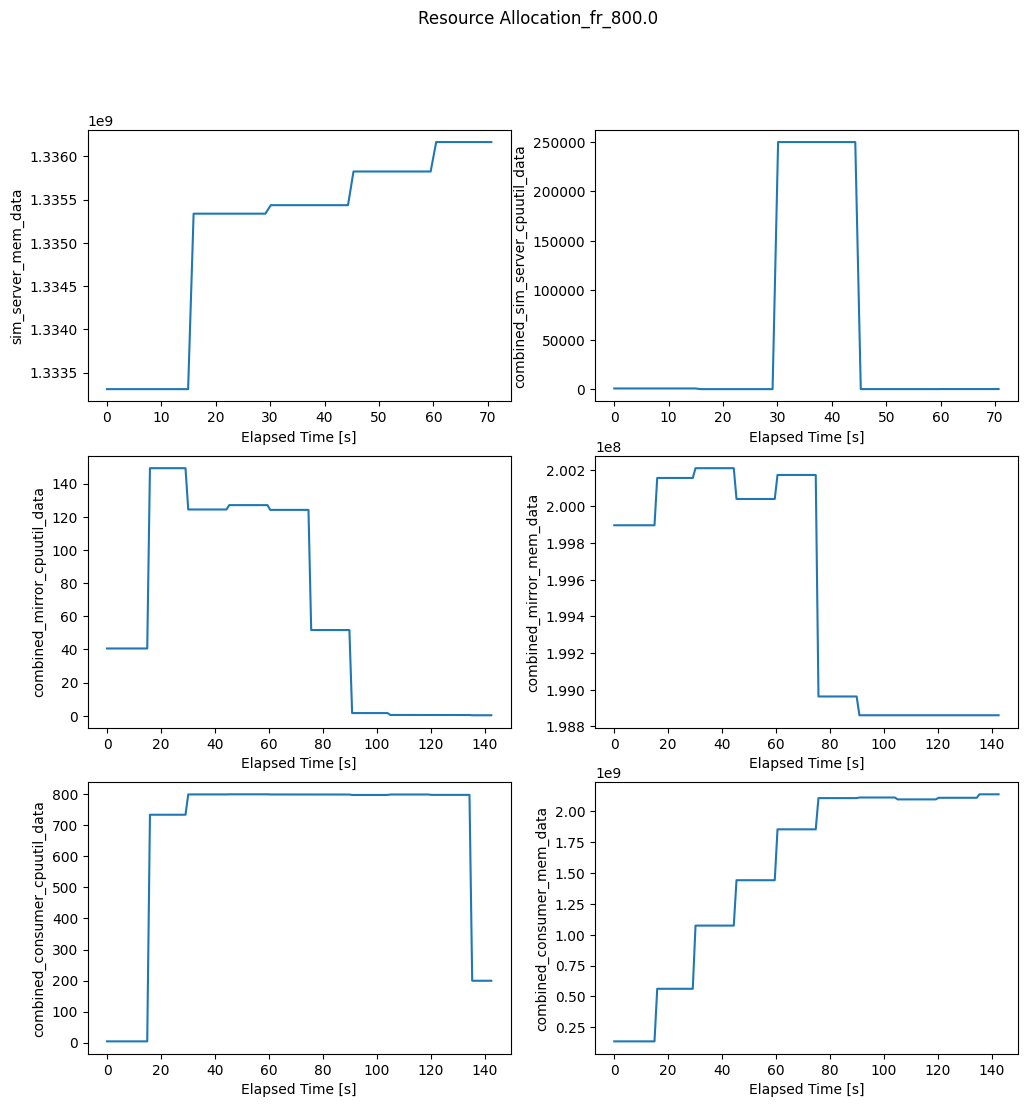

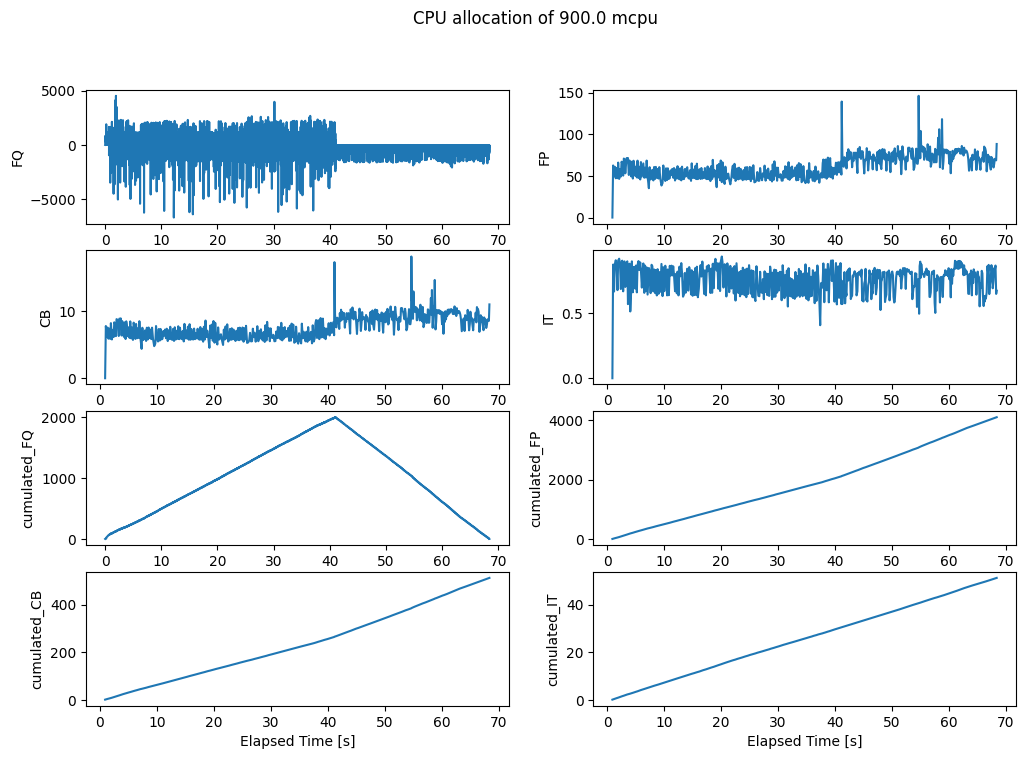

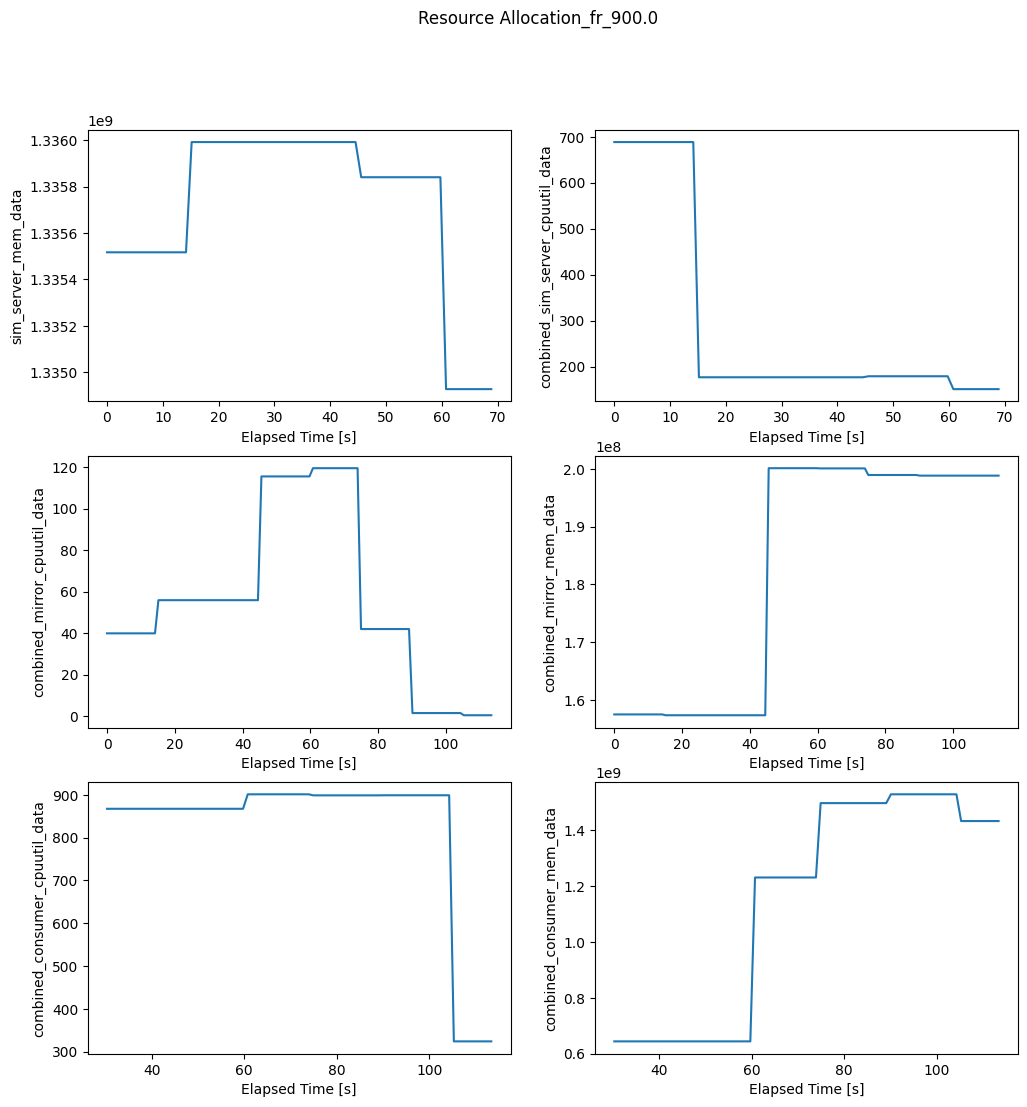

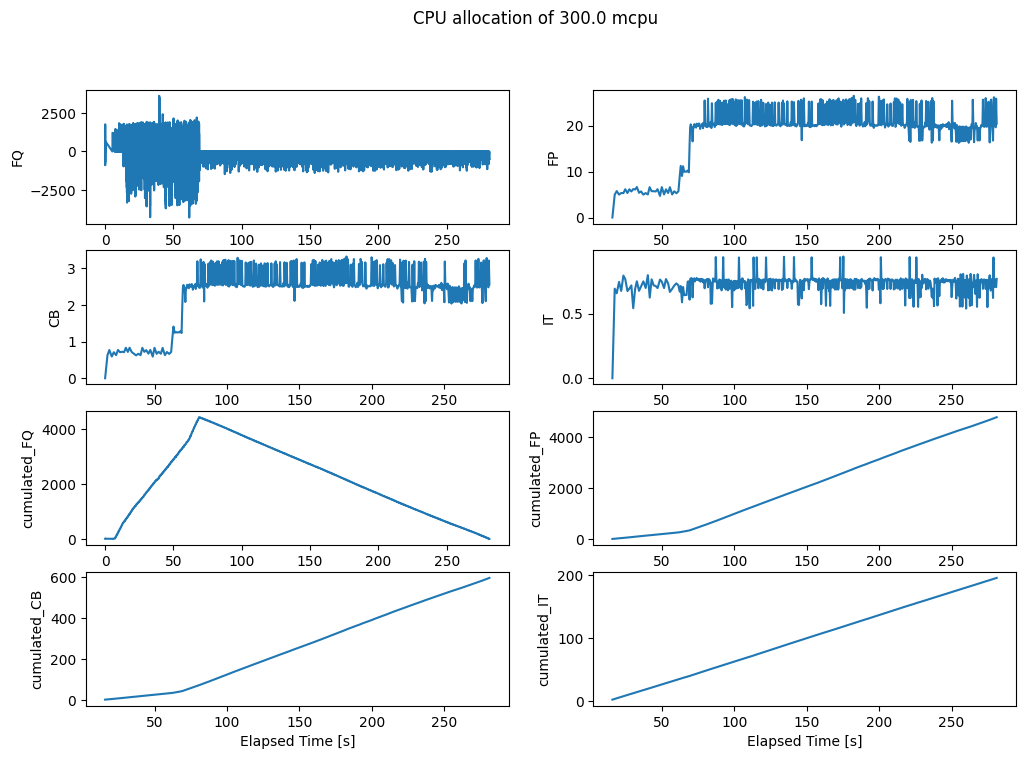

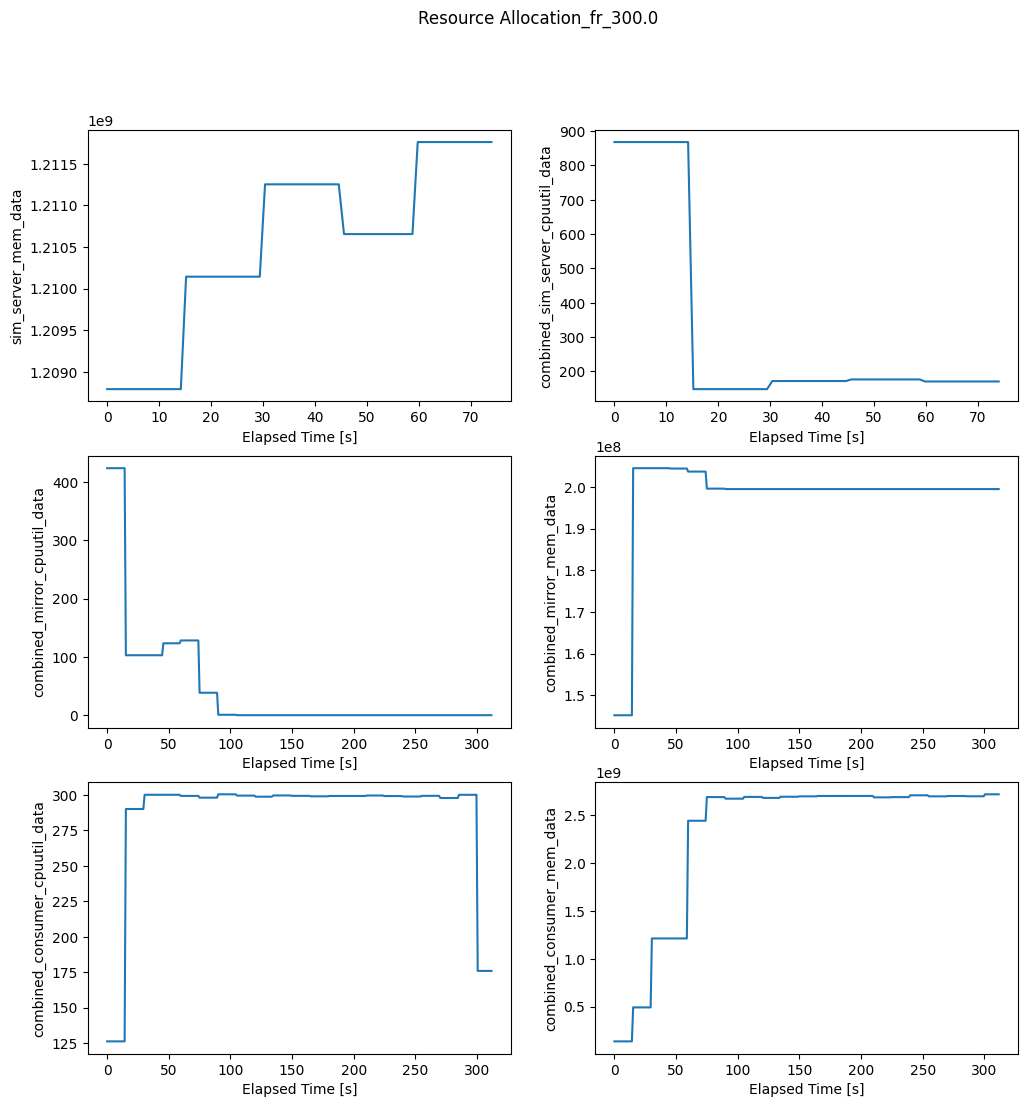

In [5]:
import os
import tarfile  # Add this import
from charon_analysis import execute_experiment
from matplotlib import pyplot as plt
import warnings
import numpy as np

warnings.filterwarnings('ignore')
label_dict = {'FQ': 'Avg. No. of Frames in Queue', 'FP': 'Avg. No. of Frames Processed/ Second', 'CB': 'Avg. No. of Batches Processed/ Second', 'IT': 'Avg. Inference Time (s)'}

WD = os.path.dirname(os.path.abspath("./playground.ipynb"))
OUTPUT_DIR = WD + "/experiment_data/RESULTS"
os.makedirs(OUTPUT_DIR, exist_ok=True)  # Create OUTPUT_DIR if it doesn't exist
print(WD)
SOURCE_D = WD + "/experiment_data/k3_identification/"
root, folder, files = next(os.walk(SOURCE_D))
for file in files:
    # print(file)
    if ".tar" in file:
        with tarfile.open(SOURCE_D + file, "r") as tar:  # Use tarfile.open
            tar.extractall(path=SOURCE_D + file[:-4])  # Extract files

FQ_x = []
FQ_y = []
FP_x = []
FP_y = []
DATA = {}

fig,axs = plt.subplots(5,1, figsize=(12, 12))  # Size in inches: 12 inches wide, 8 inches tall

root, folders, files = next(os.walk(SOURCE_D))
for fold in folders:
    if "compressed" in fold and ".tar" not in fold:
        print("------------",fold)
        CWD = SOURCE_D + f"{fold}"
        # print(CWD)
        DATA[fold],_,_,_ = execute_experiment(CWD)

        f_file = [key for key in DATA[fold].keys() if "frame" in key][0]  # Filter keys to find f_file
        k_file = [key for key in DATA[fold].keys() if "k3" in key][0]
        plot_y_order = DATA[fold][f_file]['derived'].keys()
        plot_x_order = DATA[fold][k_file]['derived'].keys()
        # print(plot_x_order,plot_y_order)

        # Create mappings for y and x orders to their respective indices
        y_index_map = {name: idx for idx, name in enumerate(plot_y_order)}
        x_index_map = {name: idx for idx, name in enumerate(plot_x_order) if "consumer" in name}

        f_averages = [(key, DATA[fold][f_file]['derived'][key].instantaneous_data.mean()) for key in DATA[fold][f_file]['derived'].keys()]
        k_averages = [(key, DATA[fold][k_file]['derived'][key]['average']) for key in DATA[fold][k_file]['derived'].keys() if "consumer" in key] 
        for f_key, f_avg in f_averages:
            for k_key, k_avg in k_averages:
                if "cpu" in k_key:
                    if 'FQ' in f_key:
                        FQ_x.append(k_avg.iloc[0]/10)
                        FQ_y.append(f_avg)
                    elif 'FP' in f_key:
                        FP_x.append(k_avg.iloc[0]/10)
                        FP_y.append(f_avg)
                    axs[y_index_map[f_key]].set_title(f"{label_dict[f_key]} vs CPU Utilization")
                    axs[y_index_map[f_key]].scatter(k_avg.iloc[0], f_avg, label=label_dict[f_key], color='k')  # Use mapped indices
                    axs[y_index_map[f_key]].set_ylabel("Value") 
                    if f_avg > 500:
                        print("----------------------------------------------------------------------------------------",fold)
                    if 'FP' in f_key:
                        axs[4].scatter(k_avg.iloc[0],  DATA[fold][f_file]['derived'][f_key]['value'].iloc[-1], label=f_key, color='k')
                        axs[4].set_title(f"Total No. of Frames Processed vs CPU Utilization")
                        axs[4].set_xlabel("CPU UTILIZATION (mcpu)")  # Label x-axis
                        axs[4].set_ylabel("Value") 

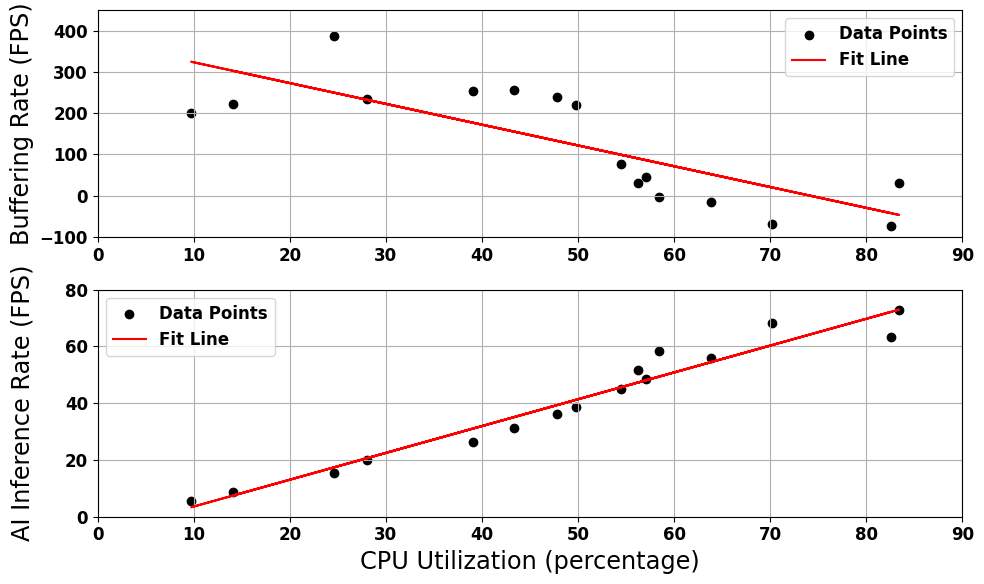

In [19]:
plt.rcParams.update({'font.size': 12, "font.weight": "bold", 'axes.labelsize': 'x-large'})
fig_r,axs_r = plt.subplots(2, 1, figsize=(10,6))
# print(DATA)
m1,b1 = np.polyfit(FQ_x,FQ_y,1)
m2,b2 = np.polyfit(FP_x,FP_y,1)
axs_r[0].scatter(FQ_x,FQ_y, color='k', label='Data Points')
axs_r[1].scatter(FP_x,FP_y, color='k', label='Data Points')

# Plot the first order lines
axs_r[0].plot(FQ_x, m1 * np.array(FQ_x) + b1, color='r', label='Fit Line')  # Add fit line for FQ
axs_r[1].plot(FP_x, m2 * np.array(FP_x) + b2, color='r', label='Fit Line')  # Add fit line for FP
axs_r[0].legend()  # Add legend for FQ plot
axs_r[1].legend()  # Add legend for FP plot

axs_r[0].set_ylim(-100, 450)  
axs_r[1].set_ylim(0, 80)  
axs_r[0].set_xlim(0, 90)  
axs_r[1].set_xlim(0, 90)
axs_r[0].grid(True)
axs_r[1].grid(True)
axs_r[0].set_ylabel("Buffering Rate (FPS)")
axs_r[1].set_ylabel("AI Inference Rate (FPS)")  
# axs_r[0].set_xlabel("Averaged CPU Utilization (percentage)") 
axs_r[1].set_xlabel("CPU Utilization (percentage)") 

fig_r.align_ylabels()
fig_r.tight_layout()
fig_r.show()
# print(os.path.join(OUTPUT_DIR, f'report.pdf'))
fig_r.savefig(os.path.join(OUTPUT_DIR, f'report.pdf'))